In [262]:
import matplotlib.pyplot as plt
# Huffman Coding Module by Bhrigu Srivastava (https://github.com/bhrigu123/huffman-coding)
from lib.huffman import HuffmanCoding
import sys
from PIL import Image
import numpy as np

## FUNCTIONS

In [263]:
# OBSOLETE
# def ConvertGrayScale(rgbImage):
#     return np.dot(rgbImage[:,:,:3], [0.2989, 0.587, 0.114])

In [264]:
def QuantizeImage(img, Q=10):
    return np.around(img/Q).astype(int)

## Step 0. Read Original Image

In [265]:
# img = plt.imread('resources/lenna.png')
img = Image.open('resources/ex616/lenna_raw.png')

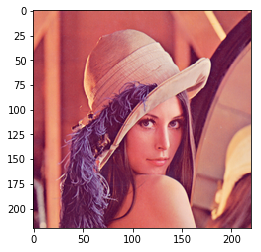

In [266]:
plt.imshow(img)

## Step 1. Convert Original Image to GrayScale

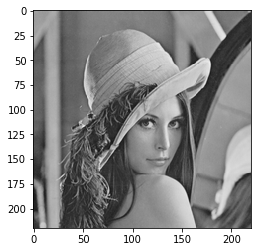

In [267]:
img2 = img.convert("L")
plt.imshow(img2, cmap='gray')

In [268]:
img2PixelValues = np.asarray(img2)
img2PixelValues

array([[162, 161, 160, ..., 165, 171, 145],
       [162, 161, 160, ..., 168, 176, 150],
       [162, 159, 159, ..., 140, 124,  89],
       ...,
       [ 50,  52,  52, ...,  70,  86,  90],
       [ 47,  50,  50, ...,  85,  98,  97],
       [ 44,  52,  48, ...,  96, 102, 105]], dtype=uint8)

## Step 2. Quantize Image

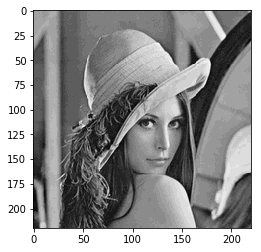

In [269]:
img3 = QuantizeImage(img2PixelValues, Q=10)
plt.imshow(img3, cmap='gray')

## Step 3. Encode Image (Using Run-Length Encoder)

In [270]:
curr_el = img3[0,0]

# encoded = [(img3.shape[0], img3.shape[1])]
encoded = ['{0};{1}'.format((0,0), curr_el)]

for i in range(img3.shape[0]):
    for j in range(img3.shape[1]):
        if not img3[i,j] == curr_el:
            curr_el = img3[i, j]
            encoded.append('{0};{1}'.format((i,j), curr_el))

## Step 4. Save (Efficiently) the Encoded Result

In [271]:
positions  = [i.split(';')[0] for i in encoded]
color_vals = [i.split(';')[1] for i in encoded]

#### Step 4.1 Save the Positions

In [272]:
current_row_index = '0'
datastream = '0'
current_col_index = 0

for position in positions[1:]:
    next_row_index, next_col_index = position.strip('()').split(', ')
    if current_row_index == next_row_index:
        datastream += ';{0}'.format(int(next_col_index)-int(current_col_index))
        current_col_index = next_col_index
    else:
        datastream += '!{0}'.format(next_col_index)
        current_col_index = next_col_index
        current_row_index = next_row_index

In [273]:
datasteam = '{0};{1};'.format(img.size[0], img.size[1]) + datastream

In [274]:
with open('resources/ex616/positions.txt', 'w') as file_handler:
    file_handler.write(''.join(datasteam))

In [275]:
path = 'resources/ex616/positions.txt'
positions_enc = HuffmanCoding(path)
positions_enc_output_path = positions_enc.compress()

Compressed


#### Step 4.2 Save the Color Values

In [276]:
with open('resources/ex616/pixelValues.txt', 'w') as file_handler:
    file_handler.write(';'.join(color_vals))

In [277]:
path = 'resources/ex616/pixelValues.txt'
pixelValues_enc = HuffmanCoding(path)
pixelValues_enc_output_path = pixelValues_enc.compress()

Compressed


## IMAGE RECONSTRUCTION

## Step 5. Decode Sequences (From .bin File -- Huffman Encoding)

#### Step 5.1 Load and Decode the Positions

In [278]:
positions_enc_decom_path = positions_enc.decompress(positions_enc_output_path)
with open('resources/ex616/positions_decompressed.txt', 'r') as fr:
    positions_datastream = fr.read()

Decompressed


In [279]:
positions_datastream = [x.split(';') for x in positions_datastream.split('!')]

In [280]:
original_dimensions = tuple([int(i) for i in positions_datastream[0][0:2]])

In [281]:
del positions_datastream[0][0:2]

In [282]:
reconstructed_positions = []
for i in range(len(positions_datastream)):
    for j in range(len(positions_datastream[i])):
        reconstructed_positions.append((i, int(positions_datastream[i][j])))

In [283]:
curr_position = reconstructed_positions[0]
for i in range(1, len(reconstructed_positions)):
    next_position = reconstructed_positions[i]
    if curr_position[0] == next_position[0]:
#         reconstructed_positions[i] = (curr_position[0], curr_position[1]+next_position[1])
        reconstructed_positions[i] = (curr_position[0], curr_position[1]+next_position[1])
    else:
        pass
    curr_position = reconstructed_positions[i]

#### Step 5.2 Load and Decode the Pixel Color Values

In [284]:
pixelValues_enc_decom_path = pixelValues_enc.decompress(pixelValues_enc_output_path)
with open('resources/ex616/pixelValues_decompressed.txt', 'r') as fr:
    pixelValues_datastream = fr.read()

Decompressed


In [285]:
reconstructed_pixelVals = [int(i) for i in pixelValues_datastream.split(';')]

## Step 6. Reconstruct the Coded Image

In [286]:
reconstructed_image = []

In [287]:
for i in range(1, len(reconstructed_positions)):
    curr_position = reconstructed_positions[i]
    prev_position = reconstructed_positions[i-1]
    
    if (curr_position[0] == prev_position[0]):
        reconstructed_image += [reconstructed_pixelVals[i-1] for x in range(curr_position[1]-prev_position[1])]
    else:
        reconstructed_image += [reconstructed_pixelVals[i-1] for x in range(original_dimensions[0] + (curr_position[1]-prev_position[1]))]    
        
reconstructed_image += [reconstructed_pixelVals[-1] for x in range(original_dimensions[0]-reconstructed_positions[-1][1])]

In [288]:
reconstructed_image = np.array(reconstructed_image, dtype=int).reshape(original_dimensions)

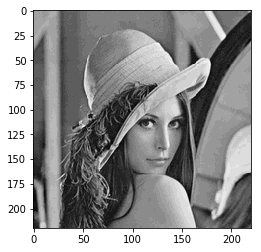

In [289]:
plt.imshow(reconstructed_image, cmap='gray')

## Step 7. Save Results (GrayScale and Quantized) for Future Reference

In [290]:
plt.imsave('resources/ex616/lenna_raw_gs.png', img2, cmap='gray')

In [291]:
plt.imsave('resources/ex616/lenna_compressed.png', reconstructed_image, cmap='gray')